### Generate Sources

In [1]:

import matplotlib
%matplotlib widget


C:\Users\Grant\AppData\Local\Temp\ipykernel_7784\187720404.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


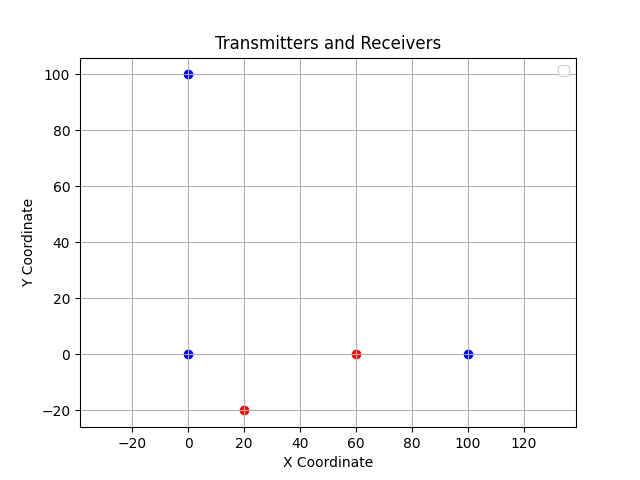

In [2]:
import matplotlib.pyplot as plt

# Define transmitters and receivers using tuples
transmitters = [[60,0], [20,-20]]

receivers = [[0, 0], [100, 0], [0, 100]]

plt.figure()

# Plot transmitters
for transmitter in transmitters:
    plt.scatter(transmitter[0], transmitter[1], color='red', label='Transmitter' if transmitter == (10, 10) else "")

# Plot receivers
for receiver in receivers:
    plt.scatter(receiver[0], receiver[1], color='blue', label='Receiver' if receiver == (0, 0) else "")

# Add labels and title
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Transmitters and Receivers')
plt.legend()
plt.grid()
plt.axis('equal')
plt.show()

# Figure out how many samples to prepend 
number_of_receivers = len(receivers)
number_of_transmitters = len(transmitters)


#### Simulate Emitted Signal which is significantly longer than the processing duration

In [3]:
import numpy as np

# lfm_waveform = np.ones(16000)
# Parameters
sampling_rate = 16000  # Samples per second
transmission_duration = 30         # Total duration of the chirp in seconds
waveform_length = sampling_rate*transmission_duration
f_start = 100          # Start frequency in Hz
f_end = 1000           # End frequency in Hz

# # Time array
# t = np.linspace(0, transmission_duration, int(sampling_rate * transmission_duration))

# # Time for the up and down segments
# half_duration = transmission_duration / 2
# t_up = t[:len(t)//2]  # First half for up chirp
# t_down = t[len(t)//2:]  # Second half for down chirp
# k = (f_end - f_start) / half_duration  # Chirp rate for up

# up_chirp   = np.sin(2 * np.pi * (f_start * t_up + 0.5 * k * t_up**2))
# down_chirp = np.flip(up_chirp)

# # Combine the up and down chirps
# lfm_waveform = np.concatenate((down_chirp,-up_chirp))

transmitted_waveforms = []
for i in range(number_of_transmitters):
    transmitted_waveforms.append(np.squeeze(np.random.normal(0, np.sqrt(10),(1,waveform_length))))

print(np.shape(transmitted_waveforms))
# plt.figure()
# plt.plot(lfm_waveform)
# plt.title("Time domain of LFM waveform")
# plt.figure()
# plt.plot(np.abs(np.fft.fftshift(np.fft.fft(lfm_waveform))))
# plt.title("Spectrum of LFM Waveform")
# plt.figure()
# plt.plot(np.abs(np.fft.ifft(np.fft.fft(lfm_waveform)*np.conj(np.fft.fft(lfm_waveform)))))
# plt.title("Spectrum of LFM Waveform")

(2, 480000)


#### Simulate Receival

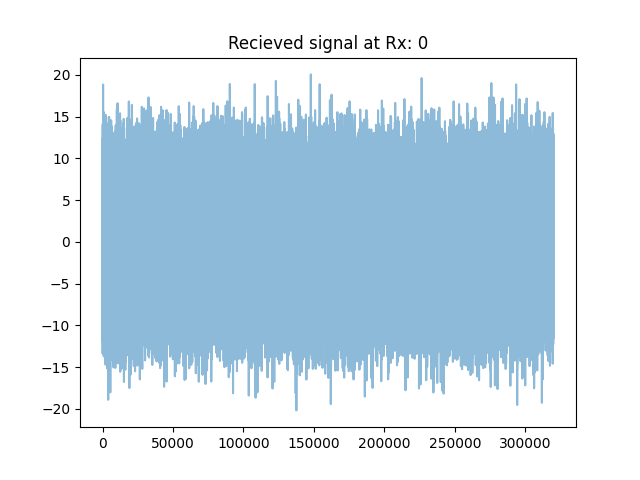

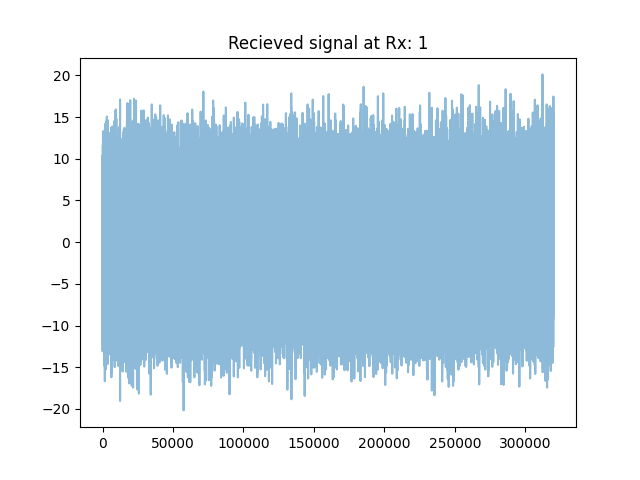

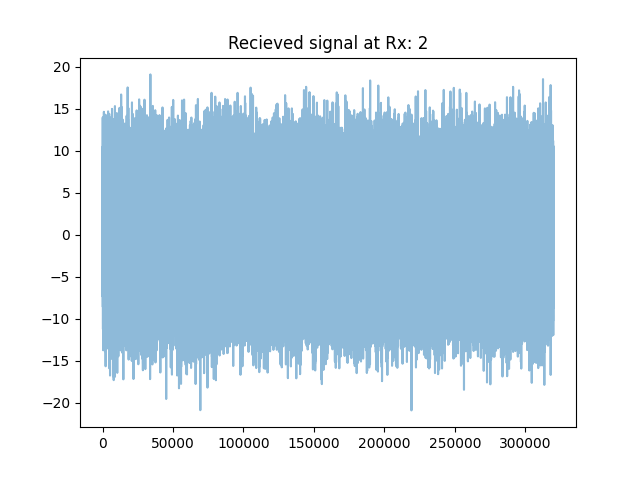

In [4]:
recording_duration_s = 35
propogation_velocity_mps = 343

period_to_analyse = 20
start_of_obervation_portion = 5

recieved_signals = []

# Function to calculate Euclidean distance
def euclidean_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

# Calculate distances between transmitters and receivers
distances = []
for transmitter in transmitters:

    distances_tmp = []

    for receiver in receivers:
        distance = euclidean_distance(transmitter, receiver)
        distances_tmp.append(distance)

    distances.append(distances_tmp)


for rx_idx in range(number_of_receivers):
    
    rxer_signal = []

    for tx_idx in range(number_of_transmitters):

        samples_in_whole_signal = recording_duration_s*sampling_rate
        rxed_signal = np.zeros(samples_in_whole_signal)
        
        # Figure out how many delay samples are requried
        distances_from_tx_to_rx_s = distances[tx_idx][rx_idx]
        delay_from_tx_to_rx_s = distances_from_tx_to_rx_s/propogation_velocity_mps
        required_prepended_samples = int(np.floor(delay_from_tx_to_rx_s*sampling_rate))

        
        # Add delays, the transmitted sig and then fill
        rxed_signal[:required_prepended_samples] = 0
        rxed_signal[required_prepended_samples:required_prepended_samples+waveform_length] = transmitted_waveforms[tx_idx]
        rxed_signal[required_prepended_samples+waveform_length:] = 0
        
        rxer_signal.append(rxed_signal)

    
        
    rxer_signal = np.sum(rxer_signal,axis=0)

    plt.figure()
    analysed_signal = rxer_signal[start_of_obervation_portion*sampling_rate: (start_of_obervation_portion+period_to_analyse)*sampling_rate]

    plt.plot(analysed_signal, alpha=0.5)
    plt.title("Recieved signal at Rx: " + str(rx_idx))
    

    recieved_signals.append(analysed_signal)


#### Add Some Noise For Fun

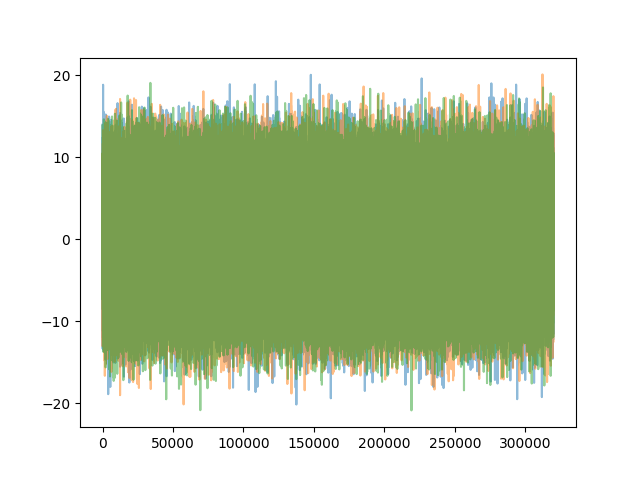

In [5]:
import numpy as np

# Assuming 'signal' is your input signal with shape (3, 160000)
receiver_count = np.shape(recieved_signals)[0]
sample_count = np.shape(recieved_signals)[1]
signal = np.random.rand(receiver_count, sample_count)  # Example signal

snr_db = 100  # Desired Signal-to-Noise Ratio in dB
plt.figure()
for rxer_ix in range(receiver_count):

    signal_power = np.mean(recieved_signals[rxer_ix]**2)

    # Convert SNR from dB to linear scale
    snr_linear = 10 ** (snr_db / 10)
    noise_power = signal_power / snr_linear

    # Generate AWGN
    noise = np.random.normal(0, np.sqrt(noise_power), recieved_signals[rxer_ix].shape)
    # Add AWGN to the signal
    recieved_signals[rxer_ix] = recieved_signals[rxer_ix] + noise
    
    plt.plot( recieved_signals[rxer_ix], alpha=0.5)

#### Simulate Signal Detection and Get Delays


auto correlation length: 639999
auto correlation mean: 1.0619031154981242
auto correlation detection indicies: (array([319999]),)


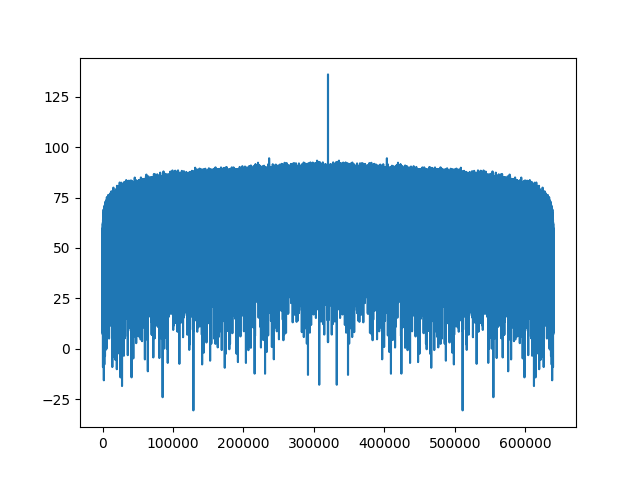

In [6]:
import scipy

reference_reciever_auto_correlation = scipy.signal.fftconvolve(recieved_signals[0], np.flip(recieved_signals[0]))
reference_reciever_auto_correlation_average = np.mean(reference_reciever_auto_correlation)
reference_reciever_auto_correlation_max_val = np.argmax(reference_reciever_auto_correlation)
reference_reciever_auto_correlation_detection_indices = np.where(reference_reciever_auto_correlation > 0.4*reference_reciever_auto_correlation_max_val)

plt.figure()
plt.plot(20*np.log10(np.abs(reference_reciever_auto_correlation)))


print("auto correlation length: " + str(len(reference_reciever_auto_correlation)))
print("auto correlation mean: " + str(reference_reciever_auto_correlation_average))
print("auto correlation detection indicies: " + str(reference_reciever_auto_correlation_detection_indices))

In [12]:
import scipy
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt

def extract_detection_indices(
    signal_1: NDArray[np.float64], 
    signal_2: NDArray[np.float64], 
    detection_threshold_above_noise_floor_db: float, 
    plot_signal: bool = False
) -> NDArray[np.float64]:
    """
    Detects and returns indices where `signal_1` and `signal_2` exceed a specified threshold above the noise floor.

    Parameters:
    ----------
    signal_1 : NDArray[np.float64]
        The first signal array for comparison.
    signal_2 : NDArray[np.float64]
        The second signal array for comparison.
    detection_threshold_above_noise_floor_db : float
        The threshold level in dB above the noise floor for detection.
    plot_signal : bool, optional (default=False)
        If True, the function will plot the signals.

    Returns:
    -------
    NDArray[np.float64]
        An array of indices where the detection condition is met.
    """
        
    # Assuming time domain signal so convert to 20*log
    cross_correlation_12 = scipy.signal.fftconvolve(signal_1,np.flip(signal_2),mode='full')
    cross_correlation_12_db = 20*np.log10(np.abs(cross_correlation_12))
    
    # Noise floor estimate - This probably takes some time
    noise_floor_estimate_db = np.average(cross_correlation_12_db)
    detection_threshold = noise_floor_estimate_db + detection_threshold_above_noise_floor_db

    # Nopw figure out where the signal is above the noise floor
    detection_indicies = np.where(cross_correlation_12_db > detection_threshold)

    if plot_signal:

        plt.figure()
        plt.title(f"Cross correlation with noise floor {noise_floor_estimate_db:.2f} dB and threshold of {detection_threshold:.2f} dB")
        plt.plot(cross_correlation_12_db)
    
    return detection_indicies

In [29]:
def calculate_detection_indicies_time_differences(
        auto_correlation_indicies,
        cross_correlation_indicies,
        sample_rate
):
    
    differential_detection_indicies = []
    
    # For every detection in the auto correlation find the sample difference 
    # to the cross correlation detection indicies
    for detection_index_1 in auto_correlation_indicies:
        for detection_index_2 in cross_correlation_indicies:
                differential_detection_indicies.append((detection_index_2 - detection_index_1)/sample_rate)
    
    return differential_detection_indicies


In [ ]:

from sympy import symbols, Eq, solve, Mul

def find_possible_hypervolic_position(x0,y0,x1,y1,delta_t,c, x_vals):    

    x, y, x_0, y_0, x_1, y_1, diff,propagation_speed  = symbols('x, y, x_0, y_0, x_1, y_1, diff,propagation_speed')
    equation01 = Eq( ((x - x_0)**2+(y - y_0)**2)**0.5 - ((x - x_1)**2+(y - y_1)**2)**0.5 , diff*propagation_speed)

    # Receiver positions
    equation01=equation01.subs(x_0, x0)
    equation01=equation01.subs(y_0, y0)
    equation01=equation01.subs(x_1, x1)
    equation01=equation01.subs(y_1, y1)

    # Constant Difference
    equation01=equation01.subs(diff, delta_t)
    equation01=equation01.subs(propagation_speed, c)

    positions_map = {}
    
    for x_tmp in  x_vals:

        equation01_tmp=equation01.subs(x,x_tmp)
        possible_y_values = solve(equation01_tmp, y, numerical=True, manual=True,simplify=False)

        for y_value in possible_y_values:
            
            # If complex not a real position
            if isinstance(y_value, Mul):
                continue
            
            # If extremely large, unexpected result and probably maybe a solver issue
            if abs(y_value) > 1e5:
                continue

            if positions_map.get(x_tmp) == None:
                positions_map[x_tmp] = []

            positions_map[x_tmp].append(y_value)

    return positions_map
           



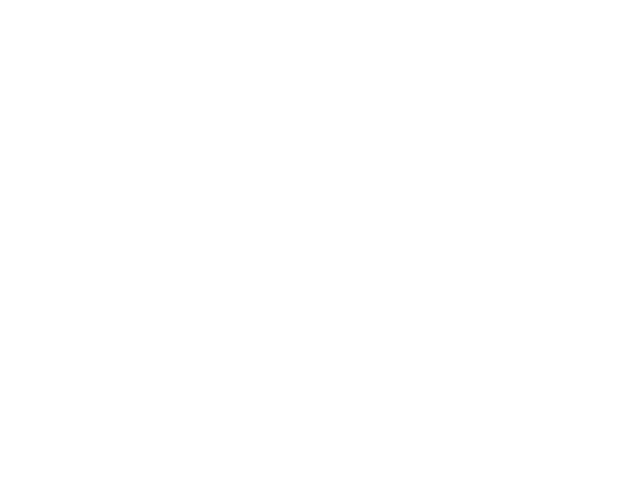

In [82]:
from sympy import symbols, Eq, solve, Mul



reference_reciever_auto_correlation_detection_indices = extract_detection_indices(recieved_signals[0], recieved_signals[0],25)
cross_01_detection_indices = extract_detection_indices(recieved_signals[0], recieved_signals[1],25)
cross_02_detection_indices = extract_detection_indices(recieved_signals[0], recieved_signals[2],25)


differential_detection_times_per_detection_01 = calculate_detection_indicies_time_differences(reference_reciever_auto_correlation_detection_indices, cross_01_detection_indices, sampling_rate)
differential_detection_times_per_detection_02 = calculate_detection_indicies_time_differences(reference_reciever_auto_correlation_detection_indices, cross_02_detection_indices, sampling_rate)

# plt.figure()
# plt.plot(np.abs(correlation12))

# plt.figure()
# plt.plot(np.abs(correlation13))


x0 = receivers[0][0]
y0 = receivers[0][1]
x1 = receivers[1][0]
y1 = receivers[1][1]
x2 = receivers[2][0]
y2 = receivers[2][1]

x_vals = np.linspace(1,100,50)
c = 343

plt.figure()

test = []

for differntial_times_for_this_detection in  differential_detection_times_per_detection_01:
    for zo in differntial_times_for_this_detection:
        test.append(find_possible_hypervolic_position(x0,y0,x1,y1,zo,c,x_vals))

for differntial_times_for_this_detection in  differential_detection_times_per_detection_02:
    for zo in differntial_times_for_this_detection:
        test.append(find_possible_hypervolic_position(x0,y0,x2,y2,zo,c,x_vals))
